# The Kinase Library
## Part A: Prediction System
### *Input*: 15-mer (15 amino acids substrate), where the central amino acid is the phospho-acceptor. <br> *Output*: Score and Percentile for the given kinases. <br> *Data provided*: 3 kinase motifs, list of scored phosphoproteome.

**Setting up the environment**

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy.stats import percentileofscore
pd.set_option('display.max.rows', 40000)

**Reading Kinase Motif files (excluding phosphopriming columns) & Scored Phosphoproteome file**

In [78]:
df_akt = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/AKT1.txt', header=0, index_col=0)
df_akt = df_akt.drop(["t", "y"], axis=1)
df_akt = df_akt.transpose()

df_cdk = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/CDK1.txt', header=0, index_col=0)
df_cdk = df_cdk.drop(["t", "y"], axis=1)
df_cdk = df_cdk.transpose()

df_erk = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/ERK1.txt', header=0, index_col=0)
df_erk = df_erk.drop(["t", "y"], axis=1)
df_erk = df_erk.transpose()

df_scores = pd.read_csv("/Users/danielbarirjensen/Desktop/Python/Datasets/Scored_Phosphoproteome.tsv", index_col=0, delimiter="\t")

**AKT1 Example**

In [79]:
df_akt

,-5,-4,-3,-2,-1,1,2,3,4
P,0.066115,0.095578,0.025668,0.015680,0.102800,0.026358,0.071930,0.115744,0.082208
G,0.075057,0.066560,0.011307,0.040903,0.090285,0.056990,0.127709,0.112188,0.077254
A,0.056223,0.055132,0.014159,0.056419,0.033349,0.020642,0.067503,0.034493,0.035566
C,0.058824,0.052787,0.014567,0.075335,0.028140,0.062831,0.094697,0.060118,0.058455
S,0.054753,0.052247,0.034353,0.194650,0.058824,0.100719,0.299389,0.096362,0.057940
T,0.054377,0.054227,0.030814,0.189400,0.050888,0.076427,0.212070,0.058824,0.085620
V,0.021737,0.024771,0.000472,0.005025,0.009462,0.054035,0.051588,0.030352,0.016429
I,0.030158,0.020086,0.000127,0.001701,0.003816,0.061065,0.027321,0.026797,0.017924
L,0.043189,0.029008,0.000395,0.018827,0.039344,0.071600,0.027663,0.032548,0.031903
M,0.040180,0.066488,0.001295,0.015746,0.065358,0.115219,0.029121,0.042528,0.049723


**Defining function to calculate score and percentile for given kinase and substrate**

In [91]:
def calculate_score_percentile(substrate, kinase):
   
    # Check for input validity
    if len(substrate) != 15:
        return "Error: substrate must have 15 amino acids"
    if substrate[7] not in ['s', 't']:
        return "Error: invalid phospho-acceptor"
    if kinase not in ['AKT1', 'CDK1', 'ERK1']:
        return "Error: invalid kinase"
    
    # Get only the relevant digits of the sequence motif excluding the middle phosphorylation site
    relevant_substrate = substrate[2:7] + substrate[8:12]
    # Convert to uppercase to match kinase matrix format
    relevant_substrate = relevant_substrate.upper()
    
    # Get probability matrix for given kinase
    if kinase == 'AKT1':
        df = df_akt
    elif kinase == 'CDK1':
        df = df_cdk
    elif kinase == 'ERK1':
        df = df_erk
        
    # Calculate score
        
    score = 1
    for aa, pos in zip(relevant_substrate, [-5,-4,-3,-2,-1,1,2,3,4]):
        if aa != '_':
            score *= df.loc[aa,pos]
        else:
            score *= 1/17
    score /= (1/17)**9
    
    ##init_score = reduce(lambda score, pair: score * pair, map(lambda pair: df.loc[pair[0],pair[1]] if pair[0] != '_' else 1/17, zip(relevant_substrate,[-5,-4,-3,-2,-1,1,2,3,4])))
    ##score = init_score/(1/17**9)
    
    # Calculate percentile
    kinase_col = df_scores[kinase]
    percentile = percentileofscore(kinase_col, score, kind='rank')
        
    # Combine results into string
    result = f"Substrate: {substrate}, Kinase: {kinase}, Score: {round(score,6)}, Percentile: {round(percentile,2)}%"
        
    return round(score,4), round(percentile,2)

**Running and validating the function**

In [104]:
substrate = '_____MEsyDVIANQ'
kinase = 'ERK1'

calculate_score_percentile(substrate, kinase)

(0.0668, 16.14)

**What is the conceptual difference between score and percentile?**

The conceptual difference between score and percentile is that the score reflects how well a substrate responds to
a given kinase, whereas the percentile indicates how that substrate performs against all other substrates for that
given kinase (takes into account the selectivity of the kinase).

## Part B: Performance Analysis
### *Input*: Kinase <br> *Output*: ROC curve and AUC <br> *Data Provided*: List of kinase-substrate pairs, human proteome

In [159]:
# Read Kinase Substrate Known Pairs file
df_knownpairs = pd.read_table('/Users/danielbarirjensen/Desktop/Python/Datasets/Kinase_Substrate_known_pairs.txt', sep='\t', header=0)

# Filter out non-human substrates and tyrosine substrates
df_knownpairs = df_knownpairs[(df_knownpairs['SUB_ORGANISM'] == 'human') & (df_knownpairs['SITE_+/-7_AA'] != 'y')]

# Create separate dataframes for each kinase
df_akt_known = df_knownpairs[df_knownpairs['KINASE'] == 'Akt1']

df_cdk_known = df_knownpairs[df_knownpairs['KINASE'] == 'CDK1']

df_erk_known = df_knownpairs[df_knownpairs['KINASE'] == 'ERK1']

### *Creating Dataframe*

In [225]:
# Create empty dataframes with column names
df_akt_result = pd.DataFrame(columns=['Substrate', 'Percentile', 'Phosphorylation'])
df_cdk_result = pd.DataFrame(columns=['Substrate', 'Percentile', 'Phosphorylation'])
df_erk_result = pd.DataFrame(columns=['Substrate', 'Percentile', 'Phosphorylation'])

# Add the list of all values in the index column of df_scores to the 'Substrate' columns
df_akt_result['Substrate'] = df_scores.index.tolist()
df_cdk_result['Substrate'] = df_scores.index.tolist()
df_erk_result['Substrate'] = df_scores.index.tolist()

# Use apply() method to calculate percentile scores and fill the 'Percentile' column
df_akt_result['Percentile'] = df_akt_result['Substrate'].apply(lambda x: calculate_score_percentile(x,'AKT1')[1])
df_cdk_result['Percentile'] = df_cdk_result['Substrate'].apply(lambda x: calculate_score_percentile(x,'CDK1')[1])
df_erk_result['Percentile'] = df_erk_result['Substrate'].apply(lambda x: calculate_score_percentile(x,'ERK1')[1])

# Set the 'Phosphorylation' column based on whether it is a known pair
df_akt_result['Phosphorylation'] = df_akt_result['Substrate'].str.upper().isin(df_akt_known['SITE_+/-7_AA'].str.upper()).apply(lambda true: 1 if true else 0)
df_cdk_result['Phosphorylation'] = df_cdk_result['Substrate'].str.upper().isin(df_cdk_known['SITE_+/-7_AA'].str.upper()).apply(lambda true: 1 if true else 0)
df_erk_result['Phosphorylation'] = df_erk_result['Substrate'].str.upper().isin(df_erk_known['SITE_+/-7_AA'].str.upper()).apply(lambda true: 1 if true else 0)


In [226]:
# Looking up count of negative substrates vs. positive substrates
print(df_akt_result['Phosphorylation'].value_counts())
print(df_cdk_result['Phosphorylation'].value_counts())
print(df_erk_result['Phosphorylation'].value_counts())

0    38327
1      238
Name: Phosphorylation, dtype: int64
0    38166
1      399
Name: Phosphorylation, dtype: int64
0    38274
1      291
Name: Phosphorylation, dtype: int64


In [228]:
# Splitting into dependent and independent variables
X_akt = df_akt_result.iloc[:,1].values
y_akt = df_akt_result.iloc[:,2].values

X_cdk = df_cdk_result.iloc[:,1].values
y_cdk = df_cdk_result.iloc[:,2].values

X_erk = df_erk_result.iloc[:,1].values
y_erk = df_erk_result.iloc[:,2].values

### *Train-Test Split*

In [230]:
from sklearn.model_selection import train_test_split

X_train_akt, X_test_akt, y_train_akt, y_test_akt = train_test_split(X, y, test_size = 0.20)
X_train_akt = np.array(X_train_akt).reshape(-1, 1)
y_train_akt = np.array(y_train_akt)
X_test_akt = np.array(X_test_akt).reshape(-1, 1)
y_test_akt = np.array(y_test_akt)

X_train_cdk, X_test_cdk, y_train_cdk, y_test_cdk = train_test_split(X, y, test_size = 0.20)
X_train_cdk = np.array(X_train_cdk).reshape(-1, 1)
y_train_cdk = np.array(y_train_cdk)
X_test_cdk = np.array(X_test_cdk).reshape(-1, 1)
y_test_cdk = np.array(y_test_cdk)

X_train_erk, X_test_erk, y_train_erk, y_test_erk = train_test_split(X, y, test_size = 0.20)
X_train_erk = np.array(X_train_erk).reshape(-1, 1)
y_train_erk = np.array(y_train_erk)
X_test_erk = np.array(X_test_erk).reshape(-1, 1)
y_test_erk = np.array(y_test_erk)

### *Logistic Classifier*

In [231]:
from sklearn.linear_model import LogisticRegression
model_logistic = LogisticRegression()

model_logistic.fit(X_train_akt, y_train_akt)
y_pred_logistic_akt = model_logistic.decision_function(X_test_akt)

model_logistic.fit(X_train_cdk, y_train_cdk)
y_pred_logistic_cdk = model_logistic.decision_function(X_test_cdk)

model_logistic.fit(X_train_erk, y_train_erk)
y_pred_logistic_erk = model_logistic.decision_function(X_test_erk)

## Plotting ROCs and comparing AUC

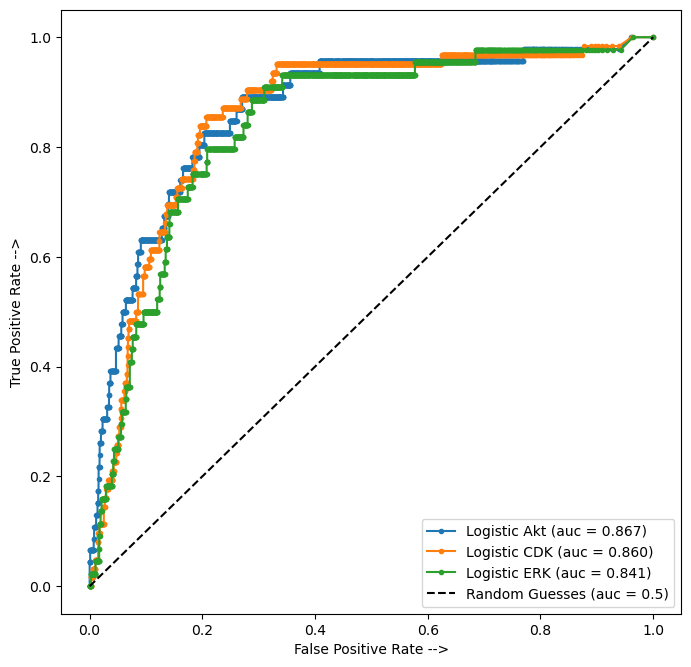

In [233]:
from sklearn.metrics import roc_curve, auc

# Calculate ROC curve and AUC for each model

logistic_fpr_akt, logistic_tpr_akt, threshold_akt = roc_curve(y_test_akt, y_pred_logistic_akt)
auc_logistic_akt = auc(logistic_fpr_akt, logistic_tpr_akt)

logistic_fpr_cdk, logistic_tpr_cdk, threshold_cdk = roc_curve(y_test_cdk, y_pred_logistic_cdk)
auc_logistic_cdk = auc(logistic_fpr_cdk, logistic_tpr_cdk)

logistic_fpr_erk, logistic_tpr_erk, threshold_erk = roc_curve(y_test_erk, y_pred_logistic_erk)
auc_logistic_erk = auc(logistic_fpr_erk, logistic_tpr_erk)

plt.figure(figsize=(8, 8), dpi=100)
plt.plot(logistic_fpr_akt, logistic_tpr_akt, marker='.', label='Logistic Akt (auc = %0.3f)' % auc_logistic_akt)
plt.plot(logistic_fpr_cdk, logistic_tpr_cdk, marker='.', label='Logistic CDK (auc = %0.3f)' % auc_logistic_cdk)
plt.plot(logistic_fpr_erk, logistic_tpr_erk, marker='.', label='Logistic ERK (auc = %0.3f)' % auc_logistic_erk)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guesses (auc = 0.5)')

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()